<img src="https://noodle.digitalfutures.com/studentuploads/Screenshot_2025-05-20_at_10.14.26.PNG" alt="Screenshot" width="100%" style="display: block; margin-left: auto; margin-right:auto;">


# Predicting Dementia - A Random Forrest Approach

## 1 - Introduction

Dementia is a broad term for an illness that causes a loss in cognitive function. The [NHS](https://www.nhs.uk/conditions/dementia/about-dementia/what-is-dementia/#:~:text=How%20common%20is%20dementia,have%20dementia%20in%20the%20UK.) estimates that in the UK, there are 994,000 people with dementia, and worryingly, a third of these are undiagnosed. There is no single test for dementia. Instead, medical professionals diagnose the condition based on a combination of examinations, clinical tests, and behavioural characteristics.  

In 2022, my wonderful mum passed away after a battle with Lewy Body Dementia. Early on, I recall her doing a cognitive test that I now know to be the Mini Mental State Exam (MMSE). This test is comprised of 30 questions, and a score of below 25 indicates dementia. My mum passed this test, but unfortunately for me and everybody whose life that she lit up, she was a false negative. 


<img src="https://noodle.digitalfutures.com/studentuploads/Screenshot_2025-05-14_at_13.31.57.png" alt="Screenshot" style="display: block; margin-left: auto; margin-right: auto; width: 40%;">   


In this investigation, I develop predictive model for dementia, employing a Random Forest approach. I am motivated to learn more about my mums set of circumstances and in particular, investigate my doubts about the effectiveness of the MMSE. More generally, I aspire to provide insight into how we might improve dementia diagnosis in the future.

These goals fall into three broad aims which govern my analysis and are as follows:  

1) Develop a model which optimises recall. Although dementia is terminal, an early diagnosis can help to slow the progression of the illness and better prepare families for caregiving.
2) Understand which tests and symptoms, as well as their combinations, are most important for providing a diagnosis.
3) Investigate feature enrichment strategies to uncover new insights and enhance model performance.

**Note:** While recall is prioritised, I am also conscious of the model’s accuracy given that overpredicting dementia incurs a cost of misclassifying other individuals.  

**Why Random Forest?**  

In future work, I will explore other models to uncover additional insights. However, I choose Random Forest as the initial approach for several reasons. First, Random Forest is robust to outliers, which are present in the dataset. I intentionally retain these outliers in the analysis as they are reflective of clinical variance. Such variance underscores the challenges in dementia diagnosis and this is the central issue I aim to address. Additionally, Random Forests can capture non-linear relationships and feature interactions, offering valuable insights, along with a ranking of feature importance that may inform clinical practices. Finally, a review of relevant academic studies demonstrates Random Forest's proven effectiveness in similar medical classification tasks.

## 2 - The Data

The dataset, available [here](https://www.kaggle.com/code/ruslankl/dementia-prediction-w-tree-based-models), is taken from the [Open Access Series of Imaging (OASIS)](https://sites.wustl.edu/oasisbrains/), a project by the Washington University School of Medicine which makes neuroimaging data freely available to the scientific community. The aim is to 'facilitate future discoveries' in clinical neuroscience. 

The dataset contains 373 records of individual imaging sessions and includes brain measurements, years of education, socioeconomic background and diagnosis. 

**Variables included in the dataset:**  
  
* **Subject ID -** A unique, anonymous identifier of individuals.
  
* **Group -** A categorical variable which indicates a person’s dementia diagnosis. 'Group' takes the values of ‘demented’, ‘non-demented’ and ‘converted’, with the latter indicating that the severity of someone’s diagnosis has been upgraded.

* **M/F -** Indicates gender and takes a value of ‘F’ for females and ‘M’ for males.

* **Age -** Indicates age, measured in years.

* **EDUC -** Indicates number of years in education, measured in years. Interestingly, [research](https://www.cam.ac.uk/research/news/why-more-education-lowers-dementia-risk) suggests that more education lowers the risk of dementia.

* **SES -** A categorical variable indicating socioeconomic status ranging from 1 (lowest) to 5 (highest).

* **MMSE -** Mini Mental State Exam score, ranging from 0 to 30. A score below 25 is indicative of dementia. The lower the score, the more severe the diagnosis.

* **eTIV -** Estimated total intracranial volume, measured in mm-cubed. An estimate of total volume inside the cranium.

* **nWBV -** A measure of brain volume, normalised to a brain atlas. A common [symptom of dementia](https://www.alzheimers.org.uk/about-dementia/symptoms-and-diagnosis/how-dementia-progresses/symptoms-brain) is brain atrophy, whereby the brain shrinks.

* **ASF -** Atlas Scaling Factor. The factor by which brains are scaled to the atlas.  


**Note**: There are other variables in the dataset which for one reason or another, are excluded from the investigation. These are detailed in section 3.

## 3 - Importing and Feature Engineering

In [475]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV    
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
import statsmodels.tools
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.ensemble import RandomForestRegressor

In [163]:
# Read CSV and save into DataFrame

file = '/Users/thomaswoodhead/Downloads/oasis_longitudinal.csv'
df = pd.read_csv(file)

**The variables to be dropped  and the reasons for their exclusions are as follows:**  

* **Visit -** The obtained measurements being observed on the n<sup>th</sup> visit adds no value to this investigation.
  
* **MR Delay -** The delay in MR results adds no value to this investigation.

* **CDR -** While the Clinical Dementia Rating may offer valuable insight as a target variable for future investigations, the present study seeks to classify individuals as having dementia or not, rather than classifying the severity of the diagnoses.

* **Subject ID** - A unique, anonymous identifier of individuals. Offers no value for classification.

* **MRI ID** - A unique, anonymous identifier of MRI scans. Offers no value for classification.

* **Hand -** Hand preference (left or right). All records are right handed. 

In [165]:
# Drop columns not used in investigation.

df.drop(columns = ['Visit', 'MR Delay', 'CDR', 'Subject ID', 'MRI ID', 'Hand' ], inplace = True)

The target column, **Group** currently takes 3 values, ‘demented’, ‘non-demented’ and  ‘converted’. Given that I am not concerned about how a diagnosis has been upgraded, only whether an individual has dementia or not, I group demented with converted. I then create a new column called ‘Demented’ that takes a value of 1 if someone has a dementia diagnoses, 0 otherwise.  

The **M/F** column must also be mapped to 1 and 0. 

In [168]:
# Creating target column

df['Demented'] = df['Group'].map({'Nondemented': 0, 'Demented': 1, 'Converted': 1})

# Map M and F to 0 and 1. 

cols = ['M/F']
for col in cols:
    unique_vals = df[col].unique()
    mapping = {val: i for i, val in enumerate(unique_vals)}
    df[col] = df[col].map(mapping)

**From the pie chart below, we can see that the target classes are well balanced.**

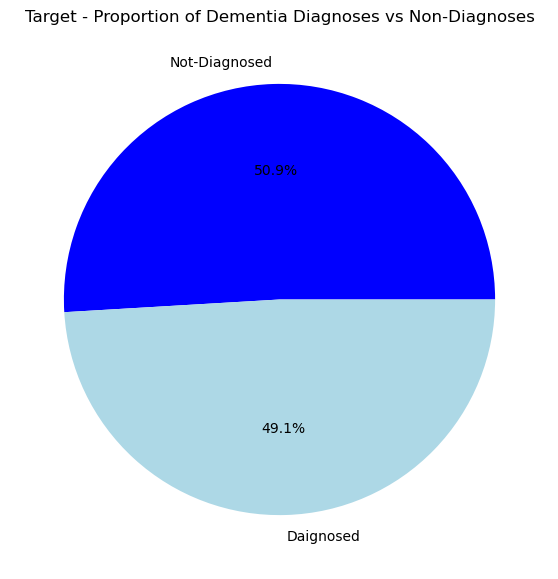

In [207]:
#Creating a pie chart

pie_ch = df.Demented.value_counts(normalize = True)
plt.figure(figsize=(7, 7))
classes = ['Not-Diagnosed', 'Daignosed']
plt.pie(pie_ch, labels=classes, autopct= '%1.1f%%' , colors=['blue','lightblue'])
plt.title('Target - Proportion of Dementia Diagnoses vs Non-Diagnoses')
plt.show()

From the table below, it is observed that **SES** and **MMSE** have missing values. In regard to **SES**, I experimented with the appropriate solution. Given that **SES** is a categorical variable and relatively speaking, 19 missing entries is not insignificant, I am reluctant to fill in the nulls with the mean or the mode of the column. Having ran estimations with the column included but the affected rows excluded, as well as estimations with this entire column excluded, I note that the model performs better with the latter approach. As such, **SES** is not used in this investigation. For the missing **MMSE**, both missing values were for the same individual who had 3 tests in total and so I fill the null values with the score of their other test.

In [202]:
df.isnull().sum()

Group        0
M/F          0
Age          0
EDUC         0
SES         19
MMSE         2
eTIV         0
nWBV         0
ASF          0
Demented     0
dtype: int64

In [211]:
# Filling NA's of missing MMSE

df['MMSE'] = df['MMSE'].fillna(26.0)

## 3 - Descriptive Data Exploration

In [214]:
df.corr(numeric_only = True)

,M/F,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF,Demented
M/F,1.000000,0.037726,-0.089279,0.045776,0.164762,-0.572549,0.249618,0.561647,-0.222146
Age,0.037726,1.000000,-0.027886,-0.046857,0.055848,0.042348,-0.518359,-0.035067,-0.005941
EDUC,-0.089279,-0.027886,1.000000,-0.722647,0.196159,0.257015,-0.012200,-0.241752,-0.193060
SES,0.045776,-0.046857,-0.722647,1.000000,-0.149219,-0.261575,0.090095,0.255576,0.062463
MMSE,0.164762,0.055848,0.196159,-0.149219,1.000000,-0.028163,0.341315,0.035034,-0.525117
eTIV,-0.572549,0.042348,0.257015,-0.261575,-0.028163,1.000000,-0.210122,-0.988877,-0.042700
nWBV,0.249618,-0.518359,-0.012200,0.090095,0.341315,-0.210122,1.000000,0.213476,-0.311346
ASF,0.561647,-0.035067,-0.241752,0.255576,0.035034,-0.988877,0.213476,1.000000,0.032495
Demented,-0.222146,-0.005941,-0.193060,0.062463,-0.525117,-0.042700,-0.311346,0.032495,1.000000


**Note**: Given the almost perfect negative correlation between ASF and eTIV, I drop the former from the investigation. 

**Box Plots**   

Box plotting the continuous variables based on their diagnoses helps to uncover the relationships between the features and the target. For example, we can see that while there is some overlap, lower MMSE scores are associated with dementia diagnoses. Similarly, lower brain volumes are also representative of dementia. Finaly, the box plot evidences that individuals with higher education are less susceptible to dementia. 

It is worth noting that the box plots indicate the presence of outliers, represented by the circles. I consciously keep these outliers in the analysis as they are reflective of clinical variance. Such variance makes dementia difficult to diagnose and this is the issue I seek to address.  


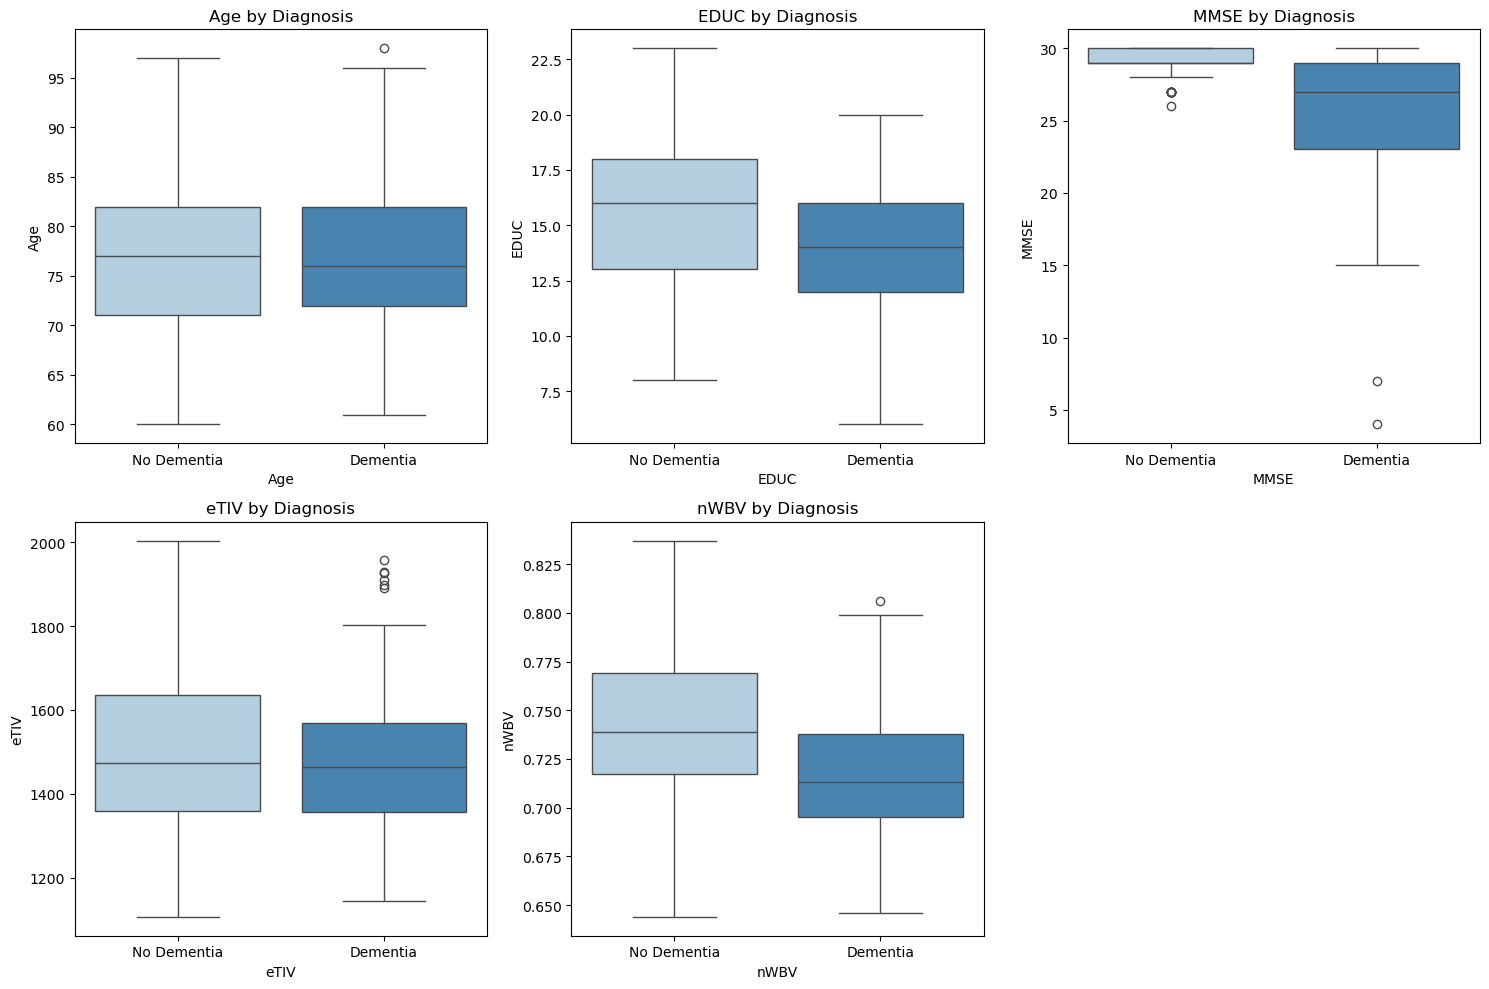

In [216]:
#Creating Box Plots

features_plot = ['Age', 'EDUC', 'MMSE', 'eTIV', 'nWBV']
plt.figure(figsize=(15,10))  
for i, feature in enumerate(features_plot):
    plt.subplot(2, 3,  i + 1) 
    sns.boxplot(y=df[feature],x=df['Demented'].map({0:'No Dementia', 1: 'Dementia'}),palette= 'Blues')
    plt.xlabel(feature)
    plt.title(f'{feature} by Diagnosis')
    plt.xticks([0, 1], ['No Dementia','Dementia' ])
plt.tight_layout()
plt.show()


**I also explore the descriptive statistics which will become relevant later.**

In [393]:
df.corr(numeric_only = True)

,M/F,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF,Demented
M/F,1.000000,0.037726,-0.089279,0.045776,0.164762,-0.572549,0.249618,0.561647,-0.222146
Age,0.037726,1.000000,-0.027886,-0.046857,0.055848,0.042348,-0.518359,-0.035067,-0.005941
EDUC,-0.089279,-0.027886,1.000000,-0.722647,0.196159,0.257015,-0.012200,-0.241752,-0.193060
SES,0.045776,-0.046857,-0.722647,1.000000,-0.149219,-0.261575,0.090095,0.255576,0.062463
MMSE,0.164762,0.055848,0.196159,-0.149219,1.000000,-0.028163,0.341315,0.035034,-0.525117
eTIV,-0.572549,0.042348,0.257015,-0.261575,-0.028163,1.000000,-0.210122,-0.988877,-0.042700
nWBV,0.249618,-0.518359,-0.012200,0.090095,0.341315,-0.210122,1.000000,0.213476,-0.311346
ASF,0.561647,-0.035067,-0.241752,0.255576,0.035034,-0.988877,0.213476,1.000000,0.032495
Demented,-0.222146,-0.005941,-0.193060,0.062463,-0.525117,-0.042700,-0.311346,0.032495,1.000000


## 4 - The Benchmark Model  

I first develop a benchmark model with the selected features. This model is the product of finetuning by means of random search. This benchmark model provides a baseline against which subsequent models can be compared to.

In [339]:
feature_cols = [ 'M/F', 'Age', 'EDUC', 'MMSE', 'eTIV', 'nWBV']
X = df[feature_cols]
y = df.Demented
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state= 33)
rf = RandomForestClassifier(n_estimators=50)

In [346]:
rf_params = {
    'n_estimators': [100],         
    'max_depth': [7],                
    'min_samples_split': [20],     
    'min_samples_leaf': [12],        
    'max_features': ['sqrt']}

gs = GridSearchCV(rf, param_grid=rf_params, cv=5, n_jobs=-1, scoring ='recall')       
gs.fit(X_train, y_train)
rf_best = gs.best_estimator_

In [367]:
y_train_pred = rf_best.predict(X_train)
y_test_pred = rf_best.predict(X_test)
#Print the metrics
print(f'Train Recall: {recall_score(y_train, y_train_pred)}')
print(f'Test Recall: {recall_score(y_test, y_test_pred)}')
print(f'Train Acc:{rf_best.score(X_train, y_train)}')
print(f'Test Acc:{rf_best.score(X_test, y_test)}')

Train Recall: 0.7876712328767124
Test Recall: 0.7837837837837838
Train Acc:0.8489932885906041
Test Acc:0.8533333333333334


In [357]:
y_pred = rf_best.predict(X_test)
metrics.confusion_matrix(y_test, y_pred)

array([[35,  3],
       [ 8, 29]])

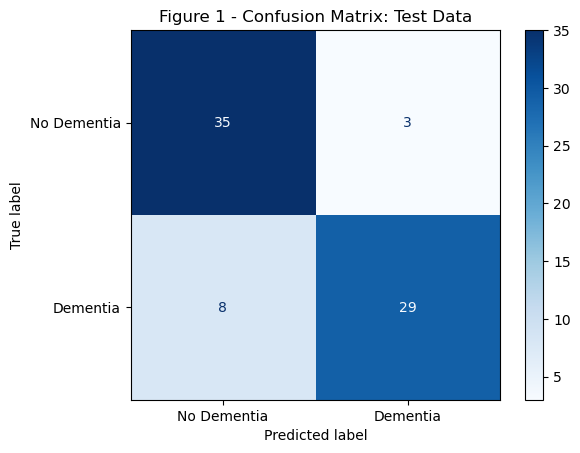

In [365]:
cm = np.array([[35,  3],
       [ 8, 29]])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Dementia','Dementia'])

disp.plot(cmap='Blues')
plt.title("Figure 1 - Confusion Matrix: Test Data")
plt.show()

In [370]:
y_pred = rf_best.predict(X_train)
metrics.confusion_matrix(y_train, y_pred)

array([[138,  14],
       [ 31, 115]])

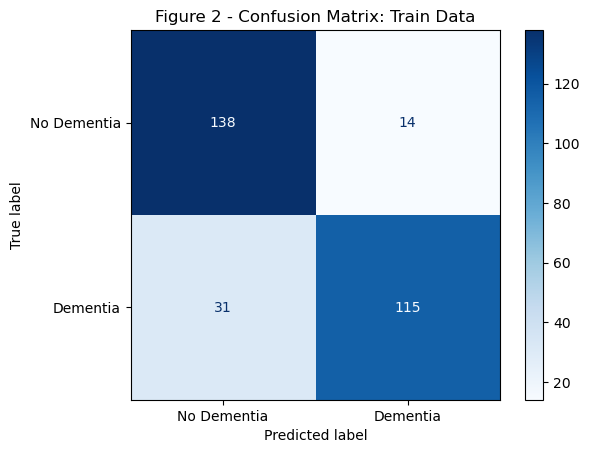

In [373]:
cm = np.array([[138,  14],
       [ 31, 115]])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['No Dementia', 'Dementia'])

disp.plot(cmap ='Blues')
plt.title("Figure 2 - Confusion Matrix: Train Data")
plt.show()

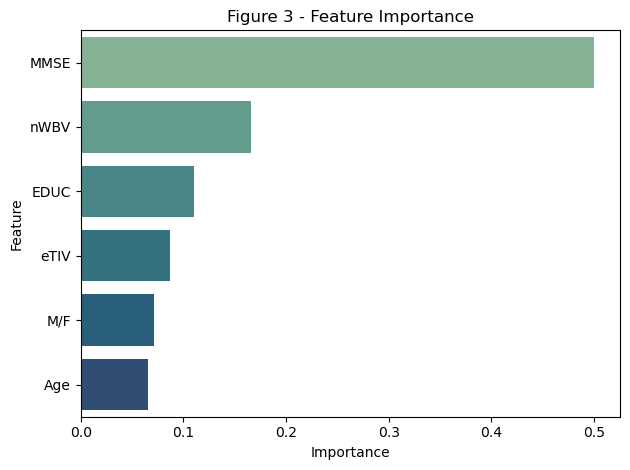

In [383]:
#Plotting Feature Importance

importance = list(zip(feature_cols, list(rf_best.feature_importances_)))
FI = pd.DataFrame(importance, columns = ['Feature', 'Importance'])
FI = FI.sort_values(by = 'Importance', ascending = False)

sns.barplot(x ='Importance', y='Feature', data = FI, palette= 'crest')

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Figure 3 - Feature Importance')

plt.tight_layout()
plt.show()

**Metric Summary – Benchmark Model**   
Train Recall: 78.8%  
Test Recall: 78.4%  
Train Accuracy: 84.9%  
Test Accuracy: 85.3%  

Figure 3 plots the feature importance. The most important feature is the MMSE score, which reduces the class impurity 50.9% of the time. This would suggest that any preconceived bias I had against the MMSE derived from my mums false negative was flawed. However, while the metrics are reasonable, figure 1 shows that there are 8 false negatives in my test set. This warrants further investigation. As such, all false negatives from the test data are grouped together. 

In [390]:
# Grouping false negatives in the test set

test_results = X_test.copy()
test_results['y_pred'] = rf_best.predict(X_test)
test_results['y_real'] = y_test
test_results['y_prob'] = rf_best.predict_proba(X_test)[:,1]
test_results[(test_results['y_pred'] == 0) & (test_results['y_real'] ==1)].head(20)

,M/F,Age,EDUC,MMSE,eTIV,nWBV,y_pred,y_real,y_prob
321,1,76,14,28.0,1236,0.764,0,1,0.449041
265,0,86,18,30.0,1670,0.669,0,1,0.362346
275,1,70,11,29.0,1295,0.748,0,1,0.425341
205,0,66,12,30.0,1446,0.780,0,1,0.352157
263,0,81,18,29.0,1647,0.717,0,1,0.443821
296,0,79,16,30.0,1722,0.708,0,1,0.491951
114,1,85,18,29.0,1264,0.701,0,1,0.196750
273,1,78,12,29.0,1475,0.731,0,1,0.351001


Upon review of the false negatives, it is apparent that they all have one thing in common; they all have above average **MMSE** scores. The sample average score is 27 while the scores for the false negatives range from 28-30. Interestingly, this mirrors my mum’s experience: a high **MMSE** score leading to a false negative. This realisation sparked a deep curiosity in me to understand the underlying factors at play. Perhaps some individuals are predisposed to perform well on the **MMSE** despite cognitive decline. Consequentially, if we can measures how well someone might perform on the **MMSE** in the absence of dementia, this measure can be used to discount the **MMSE** and may improve recall. In the dataset, years of education is available. To investigate this, I discount **MMSE** by **EDUC** and include it as new variable in the Random Forest.

## 5 - The Discounted MMSE Model

In [425]:
# Adding MMSE/EDUC to the DataFrame

df2 = df.copy()
df2['MMSE/EDUC'] = df2.MMSE / df2.EDUC

In [427]:
feature_cols2 = [  'M/F', 'Age', 'EDUC', 'eTIV', 'nWBV', 'MMSE/EDUC', 'MMSE'] 
X2 = df2[feature_cols2]
y2 = df2.Demented
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size =0.2, random_state = 33)

In [429]:
rf2 = RandomForestClassifier(n_estimators=50)
rf2_params = {
    'n_estimators': [100] ,        
    'max_depth': [6],                
    'min_samples_split': [14],     
    'min_samples_leaf': [13],        
    'max_features': ['sqrt', 'log2'],        
    'bootstrap': [False]}

gs2 = GridSearchCV(rf2, param_grid=rf2_params, cv=5, n_jobs = -1, scoring = 'recall')       

gs2.fit(X_train2, y_train2)     
rf2_best = gs2.best_estimator_

In [432]:
y_train_pred2 = rf2_best.predict(X_train2)
y_test_pred2 = rf2_best.predict(X_test2)
#Print the metrics
print(f'Train Recall: {recall_score(y_train2, y_train_pred2)}')
print(f'Test Recall: {recall_score(y_test2, y_test_pred2)}')
print(f'Train Acc:{rf2_best.score(X_train2, y_train2)}')
print(f'Test Acc:{rf2_best.score(X_test2, y_test2)}')

Train Recall: 0.815068493150685
Test Recall: 0.8108108108108109
Train Acc:0.8691275167785235
Test Acc:0.8533333333333334


In [434]:
y_pred2 = rf2_best.predict(X_test2)
metrics.confusion_matrix(y_test2, y_pred2)

array([[34,  4],
       [ 7, 30]])

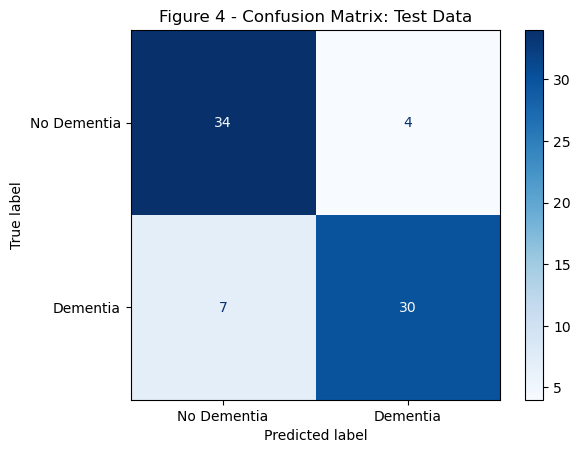

In [436]:
cm = np.array([[34,  4],
       [ 7, 30]])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Dementia','Dementia'])

disp.plot(cmap='Blues')
plt.title("Figure 4 - Confusion Matrix: Test Data")
plt.show()

In [438]:
y_pred2 = rf2_best.predict(X_train2)
metrics.confusion_matrix(y_train2, y_pred2)

array([[140,  12],
       [ 27, 119]])

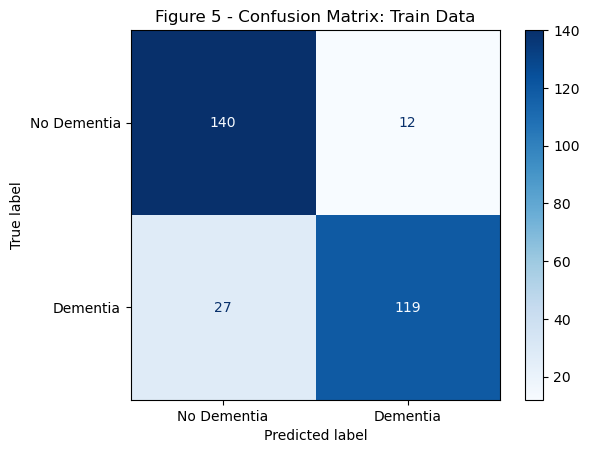

In [440]:
cm = np.array([[140,  12],
       [ 27, 119]])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Dementia','Dementia'])

disp.plot(cmap='Blues')
plt.title("Figure 5 - Confusion Matrix: Train Data")
plt.show()

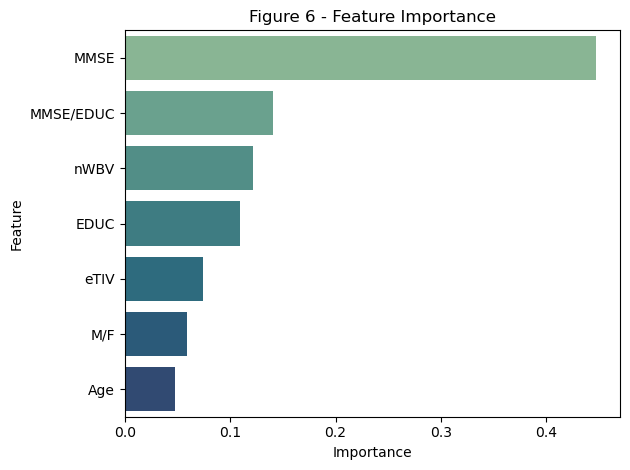

In [446]:
#Plotting Feature Importance

importance2 = list(zip(feature_cols2, list(rf2_best.feature_importances_)))
FI2 = pd.DataFrame(importance2, columns = ['Feature', 'Importance'])
FI2 = FI2.sort_values(by = 'Importance', ascending = False)

sns.barplot(x ='Importance', y='Feature', data = FI2, palette= 'crest')

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Figure 6 - Feature Importance')

plt.tight_layout()
plt.show()

**Metric Summary – Discounted MMSE Model**   
Train Recall: 81.5%    
Test Recall: 81.1%    
Train Accuracy: 86.9%  
Test Accuracy: 85.3%  

**What have we learned?**  

After finetuning the hyperparameters, the metrics indicate that by discounting **MMSE** by **Education**, recall is improved by 2.7%. This suggests that education can predispose individuals to performing well on the cognitive tests,  masking their dementia. This is important for two reasons. First, we can reduce false negatives by including a value of the **MMSE** discounted by some factor that measures how well someone would perform in the absence of dementia. Second, this finding signifies a promising avenue of development. Years of education is only a weak proxy for general cognitive ability. In the future, **MMSE** may be discounted by more effective measures such as cognitive tests that are less affected by dementia, or a record of how well someone performed on the **MMSE** before dementia was present. 

Figure 6 shows that **MMSE** is still the most important feature for determining dementia, however it is now followed by **MMSE/EDUC**. **Education** has a dual role. Individuals who are more educated are less susceptible to developing dementia, but if they do develop the illness, they are more likely to be a false negative due to their predisposition in regard to the **MMSE**.

## 6 - The Final Model

Attention is now drawn towards **nWBV**, the measure of brain volume. Brain atrophy is a term describing the shrinkage of brain volume. While this occurs due to dementia, it also occurs naturally, as part of the aging process. In this section, I propose a method of isolating atrophic effects that are a result of dementia, as opposed those that are a result of aging.   

To construct this measure, I take healthy individuals from the training set and regress their brain volumes against their age. This allows me to estimate a healthy brain volume for all ages. For every record in the sample, I then calculate the difference between the age adjusted healthy brain volume and their actual brain volume. This variable is called **residual_nWBV** and a negative value is an estimate of brain atrophy attributed to dementia. 


In [1568]:
df3 = df2.copy()
feature_cols3 = [ 'M/F',  'EDUC', 'nWBV', 'MMSE/EDUC', 'MMSE', 'Age', 'eTIV'] 
X3 = df3[feature_cols3]
y3 = df3.Demented
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size =0.2, random_state = 33)

In [1570]:
# Create a copy of the training data with only healthy individuals
train_copy = X_train3.copy()
train_copy['Demented']= y_train3
healthy = train_copy[train_copy['Demented'] == 0]

# Train regressor - Age on healthy brain volumes
reg_nwbv = RandomForestRegressor(n_estimators=100, random_state = 33)
reg_nwbv.fit(healthy[['Age']], healthy['nWBV'])

#Calulate Healthy Brain Volume
X_train3['predicted_nWBV'] = reg_nwbv.predict(X_train3[['Age']])
X_test3['predicted_nWBV'] = reg_nwbv.predict(X_test3[['Age']])

# Compute residuals by subtracting predicted from observed
X_train3['residual_nWBV'] = X_train3['nWBV'] - X_train3['predicted_nWBV']
X_test3['residual_nWBV']= X_test3['nWBV'] - X_test3['predicted_nWBV']

In [1571]:
# Dropping predicted_nWBV and nWBV from the sample as they are not needed

X_train3.drop(columns = ['predicted_nWBV'], inplace= True)
X_test3.drop(columns = ['predicted_nWBV'], inplace = True)
X_train3.drop(columns = ['nWBV'], inplace = True)
X_test3.drop(columns = ['nWBV'],inplace = True)

In [1573]:
rf3 = RandomForestClassifier(n_estimators=50)
rf3_params = {'n_estimators': [150] ,   
    'max_depth': [7],               
    'min_samples_split': [15],
    'min_samples_leaf': [15],   
    'max_features': ['sqrt', 'log2'],  
    'bootstrap': [False]}

gs3 = GridSearchCV(rf3, param_grid=rf3_params, cv=5, n_jobs = -1, scoring ='recall')       

gs3.fit(X_train3, y_train3) 
rf3_best = gs3.best_estimator_

In [1575]:
y_train_probs = rf3_best.predict_proba(X_train3)[:, 1]
y_test_probs = rf3_best.predict_proba(X_test3)[:, 1]

# Introduce a threshold
threshold = 0.47
y_train_pred_thresh = (y_train_probs > threshold)
y_test_pred_thresh = (y_test_probs > threshold)

print(f"Train Recall (threshold={threshold}) : {recall_score(y_train3, y_train_pred_thresh)}")
print(f"Test Recall (threshold={threshold}) : {recall_score(y_test3, y_test_pred_thresh)}")
print(f"Train Accuracy (threshold={threshold}) : {accuracy_score(y_train3, y_train_pred_thresh)}")
print(f"Test Accuracy  (threshold={threshold}) : {accuracy_score(y_test3, y_test_pred_thresh)}")

Train Recall (threshold=0.47) : 0.8493150684931506
Test Recall (threshold=0.47) : 0.8378378378378378
Train Accuracy (threshold=0.47) : 0.8624161073825504
Test Accuracy  (threshold=0.47) : 0.8266666666666667


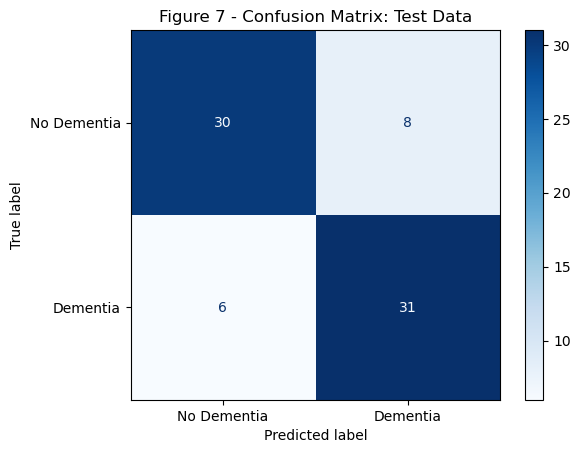

In [1496]:
# Plotting test confusion matrix 

y_test_probs3 = rf3_best.predict_proba(X_test3)[:, 1]
y_test_pred3= (y_test_probs3 >= 0.47)
conmat = confusion_matrix(y_test3, y_test_pred3)

disp = ConfusionMatrixDisplay(confusion_matrix=conmat, display_labels=['No Dementia', 'Dementia'])

disp.plot(cmap='Blues')
plt.title("Figure 7 - Confusion Matrix: Test Data")
plt.show()

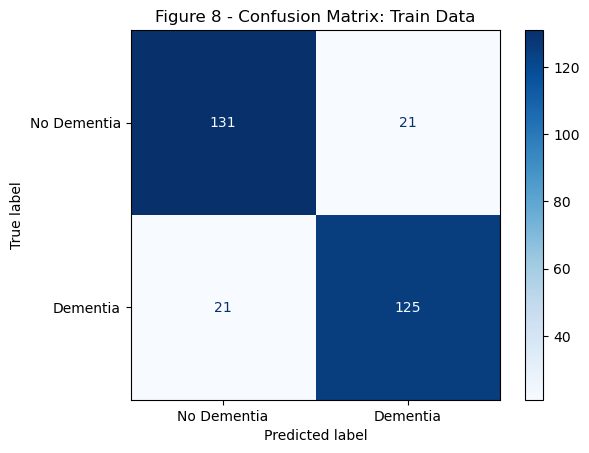

In [1225]:
# Plotting train confusion matrix 

y_train_probs3 = rf3_best.predict_proba(X_train3)[:, 1]
y_train_pred3= (y_train_probs3 >= 0.47)
conmat = confusion_matrix(y_train3, y_train_pred3)
disp = ConfusionMatrixDisplay(confusion_matrix=conmat, display_labels=['No Dementia', 'Dementia'])
disp.plot(cmap='Blues')
plt.title("Figure 8 - Confusion Matrix: Train Data")
plt.show()

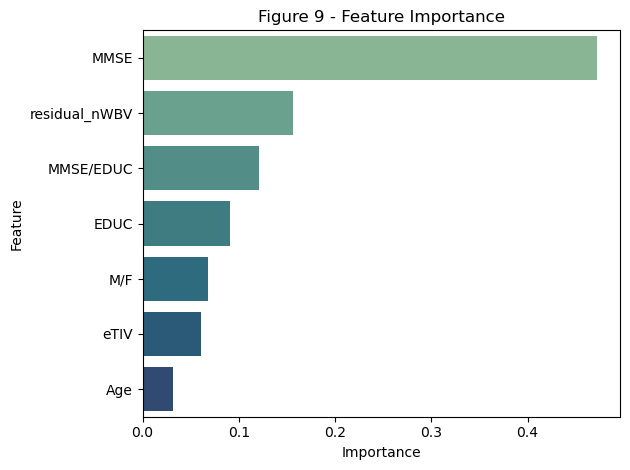

In [1227]:
# Plotting Feature Importance

importance3 = list(zip(X_test3.columns, list(rf3_best.feature_importances_)))
FI3 = pd.DataFrame(importance3, columns = ['Feature', 'Importance'])
FI3 = FI3.sort_values(by = 'Importance', ascending = False)
sns.barplot(x='Importance',y='Feature', data=FI3, palette='crest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Figure 9 - Feature Importance')

plt.tight_layout()
plt.show()

**Metric Summary – Discounted MMSE Model**   
Train Recall: 84.9%    
Test Recall: 83.8%    
Train Accuracy: 86.2%  
Test Accuracy: 82.6%  




After adapting the measure of brain volume to isolate dementia induced atrophic effects, and another round of fine tuning, test recall has improved by another 2.7%. **MMSE** remains the most important feature, but the adapted measure of brain volume is now second.

## 7 - Summary

From the benchmark model to the final model, test recall is improved by 5.4%. While this improvement might seem modest, given the sheer number of people with dementia, this equates to a lot of individuals and their families getting the diagnosis that they need. More importantly, this improvement sheds light on how dementia diagnosis may be improved in the future. In finding that years of education can mask cognitive decline, we are able to discount MMSE scores to capture some cases that were previously false negatives. Furthermore, this provides an opportunity to develop more effective discounting metrics, noting that years of education is only a weak proxy for general cognitive function. Perhaps it would be most effective to record how well individuals perform on cognitive tests before dementia is a problem. Given that 1 in 11 people over 65 have dementia, such a wide-scaled proactive measure can be easily justified as part of routine health checks. Furthermore, the results indicate that using estimated age adjusted deviations from healthy brain volumes are beneficial for recall when compared to using a standard measure. My estimation of a healthy brain volume for each age is crude, using only the records available to me. With more records, and more features relevant to healthy brain volume, a more accurate estimation and be calculated and this technique can be improved.  

Finally, it has been reassuring to gain a deeper understanding of my mum’s situation and in particular, find clarity in why she might have been a flase negative of the MMSE. Dementia diagnosis is difficult and my model is far from perfect. As neuroscience and machine learning progress, the collective goal has to be to increase recall to 100%. With that being said, this project is not finished. When time permits, I plan to experiment with new models and different feature enrichment strategies. In light of this, it is important to consider the **limitations** of my investigation:  

1) **Sample Size -** I only have 373 records available to me. More records equates to more statistical power and may yield new insight.

2) **Limited Features -** The dataset is not an exhaustive list of dementia tests. More features such as blood tests, CT-scan results and behavioural data will undoubtedly improve the model and again, may deliver new insight.

3) **Heterogeneity -** The target variable categorises individuals as either having or not having dementia. In reality, there are a multitude of dementia types and severities. By distinguishing between these, classification could be improved.

4) **Education as a Proxy -** Education is only a weak proxy for general cognitive ability. That is, ability to perform on the MMSE in the absence of dementia. More effective measures can further improve the model.

5) **Domain Knowledge -** I have very little understanding of clinical science. As my knowledge grows, I hope to be inspired to implement new feature enrichments.

6) **Time -** At the time of publication, this project is only 1 week old. I look forward to having more time to implement new strategies.